In [114]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "browser"

In [115]:
np.random.seed(222)

In [116]:
#defining class to represent our grid world
class GridWorld:
    """
    This class represents the whole envir
    """
    def __init__(self, n=5):
        self.n = n
        self.B = (n - 1, n - 1) 
        self.actions = ['up', 'right', 'down', 'left']
        self.action_space = len(self.actions)

    def get_starting_locations(self):
        agent_row = np.random.randint(self.n)
        agent_col = np.random.randint(self.n)
        package_row = np.random.randint(self.n)
        package_col = np.random.randint(self.n)
        
        return agent_row, agent_col, package_row, package_col

    def get_next_location(self, agent_row, agent_col, action_index):
        new_row, new_col = agent_row, agent_col
        action = self.actions[action_index]
        if action == 'up' and agent_row > 0:
            new_row -= 1
        elif action == 'right' and agent_col < self.n - 1:
            new_col += 1
        elif action == 'down' and agent_row < self.n - 1:
            new_row += 1
        elif action == 'left' and agent_col > 0:
            new_col -= 1
        return new_row, new_col

    def is_terminal_state(self, agent_row, agent_col, carrying):
        return (agent_row, agent_col) == self.B and carrying

In [117]:
class QLearningAgent:
    def __init__(self, grid_world, learning_rate=0.15, discount_factor=0.9):
        self.grid_world = grid_world
        self.q_values = np.random.rand(grid_world.n, grid_world.n, grid_world.n, grid_world.n, 2, grid_world.action_space)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        # self.epsilon = epsilon
        self.rewards = {
            'delivery': 80,
            'move': -1,
            'pickup': 20
        }

    def get_next_action(self, agent_row, agent_col, package_row, package_col, carrying, epsilon):
        if np.random.rand() < epsilon:
            return np.argmax(self.q_values[agent_row, agent_col, package_row, package_col, carrying])
        else:
            return np.random.randint(self.grid_world.action_space)

    def update_q_values(self, old_state, action_index, reward, new_state, is_terminal_state):
        if not is_terminal_state:
            old_q_value = self.q_values[old_state][action_index]
            temporal_difference = reward + (self.discount_factor * np.max(self.q_values[new_state])) - old_q_value
            self.q_values[old_state][action_index] = old_q_value + (self.learning_rate * temporal_difference)
        else:
            old_q_value = self.q_values[old_state][action_index]
            temporal_difference = reward - old_q_value
            self.q_values[old_state][action_index] = old_q_value + (self.learning_rate * temporal_difference)

In [118]:
class Training:
    def __init__(self, agent, grid_world, num_episodes=100000, max_steps_per_episode=200, epsilon=0.9):
        self.agent = agent
        self.grid_world = grid_world
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.epsilon = epsilon
        self.success_rates = []
        self.episode_lengths = []
        self.pickup_completion_rates = []
        self.delivery_completion_rates = []

        self.total_successes = 0
        self.total_pickups = 0 # keeping track of the number of pickups
        self.total_deliveries = 0 # keeping track of the number of successful deliveries
        self.q_value_diffs = []  # For q value convergence
        

    def train(self):
        for episode in range(self.num_episodes):
            agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()
            carrying = 0

            steps = 0
            old_q_values = np.copy(self.agent.q_values)
            
            for step in range(self.max_steps_per_episode):
                action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, self.epsilon)
                self.epsilon += 0.000009
                new_agent_row, new_agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)

                if (new_agent_row, new_agent_col) == (package_row, package_col) and not carrying:
                    reward = self.agent.rewards['pickup']
                    self.total_pickups += 1
                    carrying = 1
                elif (new_agent_row, new_agent_col) == self.grid_world.B and carrying:
                    reward = self.agent.rewards['delivery']
                    self.total_deliveries += 1
                    
                else:
                    reward = self.agent.rewards['move']

                old_state = (agent_row, agent_col, package_row, package_col, carrying)
                new_state = (new_agent_row, new_agent_col, package_row, package_col, carrying)
                self.agent.update_q_values(old_state, action_index, reward, new_state, self.grid_world.is_terminal_state(agent_row, agent_col, carrying))

                steps += 1

                
                
                agent_row, agent_col = new_agent_row, new_agent_col

                if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                    self.total_successes += 1
                    
                    break

            success_rate = self.total_successes / (episode + 1)
            self.success_rates.append(success_rate)
            self.episode_lengths.append(steps)

            pickup_rate = self.total_pickups / (episode + 1)
            delivery_rate = self.total_deliveries / (episode + 1)
            self.pickup_completion_rates.append(pickup_rate)
            self.delivery_completion_rates.append(delivery_rate)

            q_value_diff = np.abs(self.agent.q_values - old_q_values).sum()
            self.q_value_diffs.append(q_value_diff)
            
            
            
        print('Training complete!')

In [119]:
class Testing:
    def __init__(self, agent, grid_world, max_steps_per_episode=200):
        self.agent = agent
        self.grid_world = grid_world
        self.max_steps_per_episode = max_steps_per_episode

    def test_agent(self, num_tests=10):
        success_count = 0
        for _ in range(num_tests):
            agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()
            carrying = 0
            path = [(agent_row, agent_col)]
            for step in range(self.max_steps_per_episode):
                action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, epsilon=1.0)
                agent_row, agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)
                path.append((agent_row, agent_col))
                if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                    carrying = 1
                if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                    success_count += 1
                    print('Success')
                    break
            print(f'Path taken by agent for package location: {(package_row, package_col)} - ')
            print(path)
        print(f'Success rate: {success_count}/{num_tests}')

In [120]:
grid_world = GridWorld()
agent = QLearningAgent(grid_world)
trainer = Training(agent, grid_world)
trainer.train()

Training complete!


In [121]:
tester = Testing(agent, grid_world)
tester.test_agent(num_tests=10000)

Success
Path taken by agent for package location: (1, 2) - 
[(2, 3), (2, 2), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (0, 3) - 
[(1, 4), (1, 3), (0, 3), (1, 3), (2, 3), (3, 3), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (1, 0) - 
[(0, 3), (0, 2), (0, 1), (0, 0), (1, 0), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4)]
Success
Path taken by agent for package location: (3, 0) - 
[(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (2, 0) - 
[(1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (0, 0) - 
[(3, 0), (2, 0), (1, 0), (0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4)]
Success
Path taken by agent for package location: (4, 0) - 
[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (4, 1), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
Success
Path taken by agent f

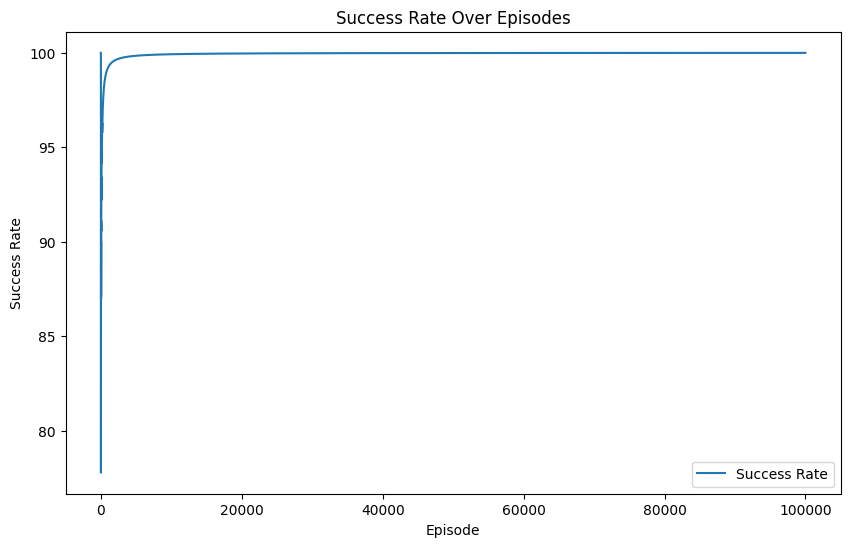

In [122]:
# Success Rate per total episodes
plt.figure(figsize=(10, 6))
plt.plot([rate*100 for rate in trainer.success_rates], label="Success Rate")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Over Episodes")
plt.legend()
plt.show()

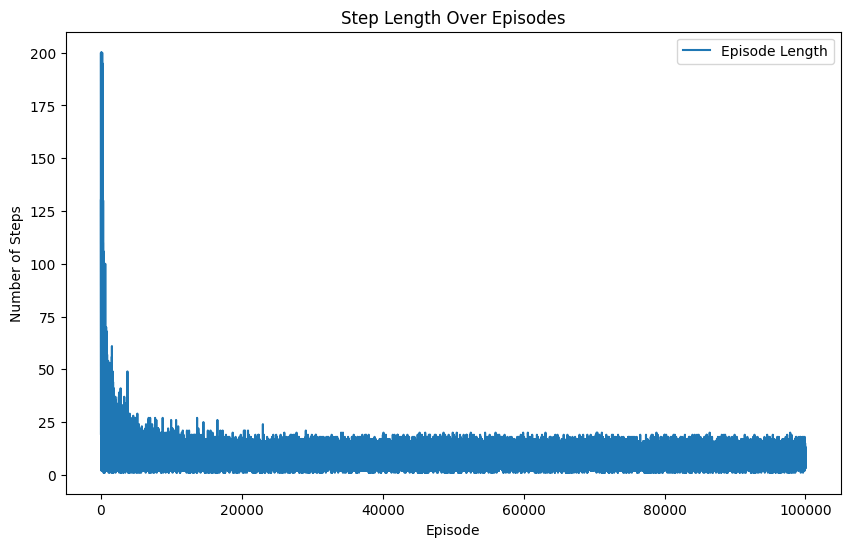

In [123]:
# No. of steps taken per episode
plt.figure(figsize=(10, 6))
plt.plot(trainer.episode_lengths, label="Episode Length")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")
plt.title("Step Length Over Episodes")
plt.legend()
plt.show()

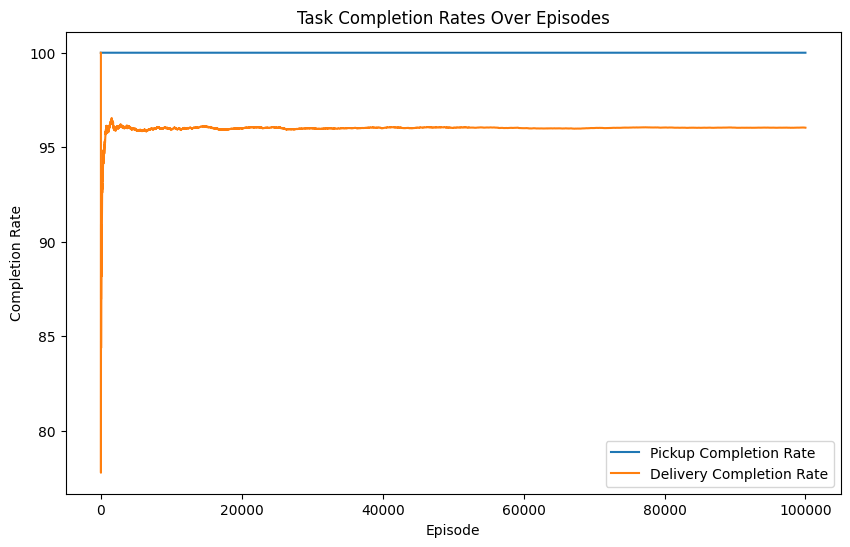

In [124]:
# Task Completion Rates for pickups and deliveries
plt.figure(figsize=(10, 6))
plt.plot([pickup*100 for pickup in trainer.pickup_completion_rates], label="Pickup Completion Rate")
plt.plot([delivery*100 for delivery in trainer.delivery_completion_rates], label="Delivery Completion Rate")
plt.xlabel("Episode")
plt.ylabel("Completion Rate")
plt.title("Task Completion Rates Over Episodes")
plt.legend()
plt.show()

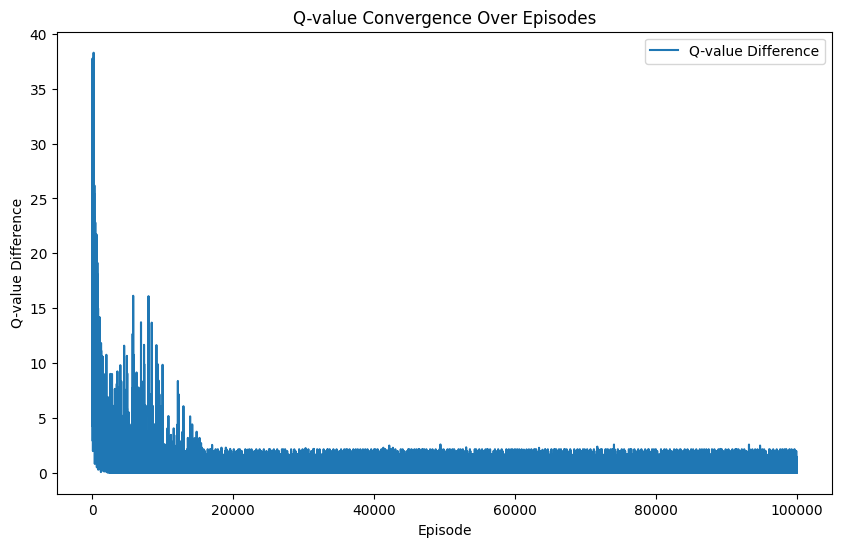

In [125]:
# Q-value Convergence
plt.figure(figsize=(10, 6))
plt.plot(trainer.q_value_diffs, label="Q-value Difference")
plt.xlabel("Episode")
plt.ylabel("Q-value Difference")
plt.title("Q-value Convergence Over Episodes")
plt.legend()
plt.show()

In [111]:
class Visualize:
    def __init__(self, grid_world, agent, trainer):
        self.grid = np.zeros((grid_world.n, grid_world.n))
        self.grid_world = grid_world
        self.agent = agent
        self.trainer = trainer
        self.carry_flag = 0


    # Visualization function
    def visualize_movement(self, agent_positions, package_location, target_location):
        frames = []
        for i, pos in enumerate(agent_positions):

            # Is the agent carrying the package?
            if (pos == package_location):
                self.carry_flag = 1

            # Create the grid in the animation
            grid_trace = go.Scatter(
                x=[0, self.grid_world.n, self.grid_world.n, 0, 0],
                y=[0, 0, self.grid_world.n, self.grid_world.n, 0],
                mode='lines',
                line=dict(color='black'),
                showlegend=False
            )
            
            # Create the agent (if not carrying) in the animation
            agent_trace = go.Scatter(
                x=[pos[1] + 0.5],
                y=[pos[0] + 0.5],
                mode='markers',
                marker=dict(size=15, color='red'),
                name='Agent'
            )

            # Create the package (if not picked up) in the animation
            if self.carry_flag == 0:
                package_trace = go.Scatter(
                    x=[package_location[1] + 0.5],
                    y=[package_location[0] + 0.5],
                    mode='markers',
                    marker=dict(size=12, color='blue', symbol='square'),
                    name='Package'
                )
            elif self.carry_flag == 1:
                package_trace = go.Scatter(x=[], y=[], mode='markers', name='Package (Picked Up)')

            # Create the target
            target_trace = go.Scatter(
                x=[target_location[1] + 0.5],
                y=[target_location[0] + 0.5],
                mode='markers',
                marker=dict(size=12, color='green', symbol='star'),
                name='Target'
            )
            
            frame = go.Frame(data=[grid_trace, agent_trace, package_trace, target_trace])
            frames.append(frame)

        return frames
    
    def simulate_agent_movement(self):
        agent_row, agent_col, package_row, package_col = self.grid_world.get_starting_locations()
        carrying = 0
        path = [(agent_row, agent_col)]
        for step in range(self.trainer.max_steps_per_episode):
            action_index = self.agent.get_next_action(agent_row, agent_col, package_row, package_col, carrying, 1.0)
            agent_row, agent_col = self.grid_world.get_next_location(agent_row, agent_col, action_index)
            path.append((agent_row, agent_col))
            if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                carrying = 1
            if self.grid_world.is_terminal_state(agent_row, agent_col, carrying):
                break

        
        
        return path, (package_row, package_col)


In [ ]:
# Visualisation during the end of training

visualizer = Visualize(grid_world, agent, trainer)

episode = 99998 # Change this to the episode number you would like to see
agent_positions = []
package_location = []
iter = trainer.path[episode]
for i in iter:
    pos = (i[0], i[1])
    agent_positions.append(pos)

package_location = (iter[0][2], iter[0][3])
print(package_location)


frames = visualizer.visualize_movement(agent_positions, package_location, (grid_world.n - 1, grid_world.n - 1))

In [113]:
fig = go.Figure(
    data=[frames[0].data[0], frames[0].data[1], frames[0].data[2], frames[0].data[3]],
    layout=go.Layout(
        xaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        yaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        title="Agent Movement Simulation",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration":500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])]
        )]
    ),
    frames=frames
)

# Show the animation
fig.show()

In [112]:
# Visualisation after training and testing agent using get_next_action() and trained agent to get optimal path

visualizer = Visualize(grid_world, agent, trainer)

agent_positions, package_location = visualizer.simulate_agent_movement()
frames = visualizer.visualize_movement(agent_positions, package_location, (grid_world.n - 1, grid_world.n - 1))

In [ ]:
fig = go.Figure(
    data=[frames[0].data[0], frames[0].data[1], frames[0].data[2], frames[0].data[3]],
    layout=go.Layout(
        xaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        yaxis=dict(range=[-1, grid_world.n+1], showgrid=True, zeroline=False, showticklabels=False),
        title="Agent Movement Simulation",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None, {"frame": {"duration":500, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])]
        )]
    ),
    frames=frames
)

# Show the animation
fig.show()